# Spline Surface
---
We want to plot a surface based on some selected points.  
Given a list of grid points $(x_k, y_l),\ k = 0,\ldots,n-1,\ l = 0,\ldots,m-1,\ $ we can use **bicubic interpolation** to approximate the surface of interest.

## Bicubic interpolation  
Bicubic interpolation is an extension of cubic interpolation for interpolating data points on a two-dimensional regular grid.  
Suppose we are ploting a surface of $f$ on the unit square $[0, 1]\times[0, 1].\ $The interpolated surface can be written as

$$p(x,y)=\sum_{i=0}^{3}\sum _{j=0}^{3} a_{ij}x^{i}y^{j}.$$  
Matching $(x,y)$ with the function values yields four equations:  
$$\begin{align*}
f(0, 0) &= a_{00},\\
f(0, 1) &= a_{00} + a_{01} + a_{02} + a_{03},\\
f(0, 1) &= a_{00} + a_{10} + a_{20} + a_{30},\\
f(1, 1) &= \sum_{i=0}^{3}\sum _{j=0}^{3} a_{ij}x^{i}y^{j}.
\end{align*}$$  
Similarly, matching $(x, y)$ with the partial derivatives of $f$ gives 12 more equations.
We can then write these equations into  
$$\left(\begin{matrix}
        f(0, 0) &&f(0, 1) &&f_y(0, 0) &&f_y(0, 1)\\
        f(1, 0) &&f(1, 1) &&f_y(1, 0) &&f_y(1, 1)\\
        f_x(0, 0) &&f_x(0, 1) &&f_{xy}(0, 0) &&f_{xy}(0, 1)\\
        f_x(1, 0) &&f_x(1, 1) &&f_{xy}(1, 0) &&f_{xy}(1, 1)
        \end{matrix}\right)
= \left(\begin{matrix}
        1 &&0 &&0 &&0\\
        1 &&1 &&1 &&1\\
        0 &&1 &&0 &&0\\
        0 &&1 &&2 &&3
        \end{matrix}\right)
  \left(\begin{matrix}
        a_{00} &&a_{01} &&a_{02} &&a_{03}\\
        a_{10} &&a_{11} &&a_{12} &&a_{13}\\
        a_{20} &&a_{21} &&a_{22} &&a_{23}\\
        a_{30} &&a_{31} &&a_{32} &&a_{33}
        \end{matrix}\right)
  \left(\begin{matrix}
        1 &&1 &&0 &&0\\
        0 &&1 &&1 &&1\\
        0 &&1 &&0 &&2\\
        0 &&1 &&0 &&3
        \end{matrix}\right),
$$
and
$$\left(\begin{matrix}
        a_{00} &&a_{01} &&a_{02} &&a_{03}\\
        a_{10} &&a_{11} &&a_{12} &&a_{13}\\
        a_{20} &&a_{21} &&a_{22} &&a_{23}\\
        a_{30} &&a_{31} &&a_{32} &&a_{33}
        \end{matrix}\right)
= \left(\begin{matrix}
        1 &&0 &&0 &&0\\
        0 &&0 &&1 &&0\\
        -3 &&3 &&-2 &&-1\\
        2 &&-2 &&1 &&1
        \end{matrix}\right)
  \left(\begin{matrix}
        f(0, 0) &&f(0, 1) &&f_y(0, 0) &&f_y(0, 1)\\
        f(1, 0) &&f(1, 1) &&f_y(1, 0) &&f_y(1, 1)\\
        f_x(0, 0) &&f_x(0, 1) &&f_{xy}(0, 0) &&f_{xy}(0, 1)\\
        f_x(1, 0) &&f_x(1, 1) &&f_{xy}(1, 0) &&f_{xy}(1, 1)
        \end{matrix}\right)
  \left(\begin{matrix}
        1 &&0 &&-3 &&2\\
        0 &&0 &&3 &&-2\\
        0 &&1 &&-2 &&1\\
        0 &&0 &&-1 &&1
        \end{matrix}\right).
$$  
Here we approximate $f_x, f_y, f_{xy}\ $by spline interpolation.

Import libraries.

In [1]:
import numpy as np
from scipy.linalg import solve_banded
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [2]:
def splineslopes(h, delta, n):
    # Getting information of A
    d1 = np.concatenate((h[1:n-1], np.array([1, 0])))
    d2 = np.concatenate((np.array([2]), 2*(h[0:n-2]+h[1:n-1]), np.array([2])))
    d3 = np.concatenate((np.array([0, 1]), h[0:n-2]))
        
    l, u, ab = 1, 1, np.array([d1, d2, d3])
    
    # Forming r
    r = np.concatenate((np.array([3*delta[0]]), 3*(h[1:n-1]*delta[0:n-2] + h[0:n-2]*delta[1:n-1]), np.array([3*delta[n-2]])))
    
    # Solve Ad = r
    return solve_banded((l, u), ab, r)

In [3]:
def getPartial(z, n, m):
    '''
    Parameters
    ----------
    z : 2D array
        values of (x, y)
    n : int
        number of x's
    m : int
        number of y's
        
    Returns
    -------
    a nxm array A with A[k, l] = partial_y of f(k, l)
    '''
    A = []
    for k in range(n):
        delta = z[k, 1: m] - z[k, 0:m-1]
        h = np.ones(m-1)
        A.append(splineslopes(h, delta, m))
    return np.asarray(A)

In [4]:
def Bicubic_UnitSquare(x, y, z, n, m):
    '''
    Parameters
    ----------
    x : 1D array
        grid points
    y : 1D array
        grid points
    z : 2D array
        values of (x, y)
    n : int
        number of x's
    m : int
        number of y's
        
    Returns
    -------
    a (n-1)x(m-1) array in which every element is a 4x4 array
    '''
    # Prepare matrix A1 and A2
    A1 = np.array([[1, 0, 0, 0],
                    [0, 0, 1, 0], 
                    [-3, 3, -2, -1], 
                    [2, -2, 1, 1]])
    A2 = np.array([[1, 0, -3, 2],
                    [0, 0, 3, -2], 
                    [0, 1, -2, 1], 
                    [0, 0, -1, 1]])
    
    # Prepare f_x, f_y, and f_xy
    partial_y = getPartial(z, n, m)
    
    partial_x = getPartial(z.T, m, n).T
    
    partial_xy = getPartial(partial_x, n, m)
    
    # Form B
    B = []
    for k in range(n-1):
        B.append([])
        for l in range(m-1):
            f = np.array([[z[k, l], z[k, l+1]],
                           [z[k+1, l], z[k+1, l+1]]])
            f_y = np.array([[partial_y[k, l], partial_y[k, l+1]],
                             [partial_y[k+1, l], partial_y[k+1, l+1]]])
            f_x = np.array([[partial_x[k, l], partial_x[k, l+1]],
                            [partial_x[k+1, l], partial_x[k+1, l+1]]])
            f_xy = np.array([[partial_xy[k, l], partial_xy[k, l+1]],
                             [partial_xy[k+1, l], partial_xy[k+1, l+1]]])
            M = np.block([[f, f_y],
                          [f_x, f_xy]])
            
            B[k].append(A1 @ M @ A2)
    
    return np.asarray(B)

In [5]:
def BicubicSpline(x, y, z):
    '''
    Parameters
    ----------
    x : 1D array
        grid points
    y : 1D array
        grid points
    z : 2D array
        values of (x, y), z[k, l] = (x_k, y_l)
        
    Returns
    -------
    function
    '''
    n, m = len(x), len(y)
    
    p = Bicubic_UnitSquare(x, y, z, n, m)
    
    def P(u, v):
        
        # Find indices k, l so that x_k <= u < x_k+1 and y_l <= v < y_l+1
        for k in range(n):
            if np.any(x[k] > u):
                break
        k -= 1
        for l in range(m):
            if np.any(y[l] > v):
                break
        l -= 1
        
        # Evaluate the interpolant
        p_kl = p[k, l]
        s = u - x[k]
        t = v - y[l]
        
        sum = 0
        for i in range(4):
            for j in range(4):
                sum += p_kl[i][j] * s**i * t**j
        return sum
    
    return P

Choose a function of interest.

In [11]:
def f(x, y):
    #return np.sin(np.sqrt((2*x) ** 2 + (2*y) ** 2))
    return x ** 2 - y ** 2

Select some points to do interpolation.

In [12]:
n = 6
pts_x = np.linspace(-n, n, 2*n + 1)
pts_y = np.linspace(-n, n, 2*n + 1)
pts_z = np.array([[f(x, y) for y in pts_y] for x in pts_x])
CS = BicubicSpline(pts_x, pts_y, pts_z)

Plot the result.

In [13]:
X, Y = np.meshgrid(pts_x, pts_y)

u = np.linspace(-6, 6, 60)
v = np.linspace(-6, 6, 60)
U, V = np.meshgrid(u, v)

W0 = f(U, V)
W1 = np.asarray([[CS(pt_u, pt_v) for pt_u in u] for pt_v in v])

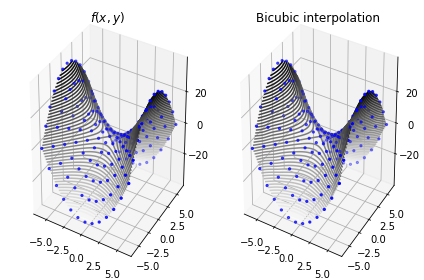

In [14]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))

ax[0].contour3D(U, V, W0, 50, cmap='binary')
ax[0].scatter3D(X, Y, f(X, Y), c='b', marker='.', cmap='Greens')
ax[1].contour3D(U, V, W1, 50, cmap='binary')
ax[1].scatter3D(X, Y, f(X, Y), c='b', marker='.', cmap='Greens')

ax[0].set_title('$f(x, y)$')
ax[1].set_title('Bicubic interpolation')
plt.tight_layout()
plt.show()

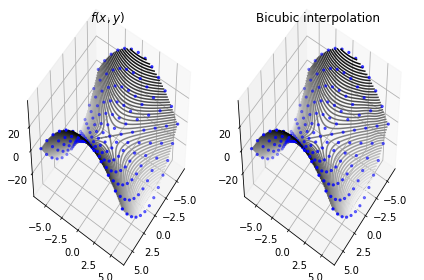

In [15]:
ax[0].view_init(50, 35)
ax[1].view_init(50, 35)
fig